In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles =  Path(r'D:\RH_local\data\scanimage data\round 6 experiments\mouse_1_18\20220215\analysis_day0').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p = Path(r'D:\RH_local\data\scanimage data\round 6 experiments\mouse_1_18\20220215\baseline\suite2p\plane0').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import *

In [5]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [6]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [7]:
dFoF_params = pickle_helpers.simple_load(path_tqm)['dFoF_params']

In [8]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [9]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [10]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [11]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(F_toUse,
                                             kernel=kernel_smoothing,
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_smooth + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
# Threshold for nonnegativity
dFoF[dFoF<0]=0

ThreadPool elapsed time : 0.04 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.09 seconds
Calculated dFoF. Total elapsed time: 5.75 seconds


# Run NMF

In [12]:
neural_data_toUse = dFoF

In [13]:
tl.set_backend('pytorch')

In [14]:
neural_data_toUse = tl.tensor(neural_data_toUse).to('cuda')

In [15]:
# Roll a dice and wish for luck
rank = 10

In [16]:
factors_nmf = tl.decomposition.non_negative_parafac(
            neural_data_toUse,
            rank=rank,
            n_iter_max=500,
            init='random',
            svd='numpy_svd', 
            tol=1e-06,
        #     random_state=None,
            verbose=0,
        #     normalize_factors=False,
        #     return_errors=False,
        #     mask=None,
        #     cvg_criterion='abs_rec_error',
        #     fixed_modes=None
        )

In [17]:
factors_temporal_nmf = np.array(factors_nmf.factors[1].to('cpu')).T

In [18]:
# nmf = sklearn.decomposition.NMF(
#     n_components=10, 
#     init='warn',
#     solver='cd',
#     beta_loss='frobenius',
#     tol=0.0001,
#     max_iter=500, 
#     random_state=None,
#     alpha='deprecated',
#     alpha_W=0.0,
#     alpha_H='same',
#     l1_ratio=0.0,
#     verbose=0,
#     shuffle=False, 
#     regularization='deprecated'
# )
# factors_neurons_nmf = nmf.fit_transform(neural_data_toUse)
# factors_temporal_nmf = nmf.components_

# Run Regression
Regress z-scored NMF temporal factors onto z-scored neural data itself

In [19]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score NMF outputs
factors_temporal_nmf_zscore = scipy.stats.zscore(factors_temporal_nmf[:,indices_to_use],axis=1)
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse.to('cpu')).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|██████████████████████████████████████████████████████████████████████████| 54000/54000 [00:06<00:00, 8016.37it/s]
D:\RH_local\github\basic_neural_processing_modules\welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


In [20]:
## Regression
regression = sklearn.linear_model.ElasticNet(
    alpha=1.0, 
    l1_ratio=0.5,
    fit_intercept=True,
    normalize='deprecated', 
    precompute=False,
    max_iter=1000, 
    copy_X=True,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None, 
    selection='cyclic'
)
regression.fit(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)
factors_temporal_regression = regression.predict(neural_data_toUse_zscore.T).T

In [21]:
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T, factors_temporal_nmf_zscore.T)
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]

In [22]:
factors_temporal_tokeep.shape

(8, 36000)

# Run PCA

In [23]:
## PCA
pca = sklearn.decomposition.PCA(
    n_components=None,
    copy=True, 
    whiten=False, 
    svd_solver='auto',
    tol=0.0, 
    iterated_power='auto',
    random_state=None
)
comp = pca.fit_transform(scipy.stats.zscore(factors_temporal_tokeep,axis =1).T).T

<IPython.core.display.Javascript object>


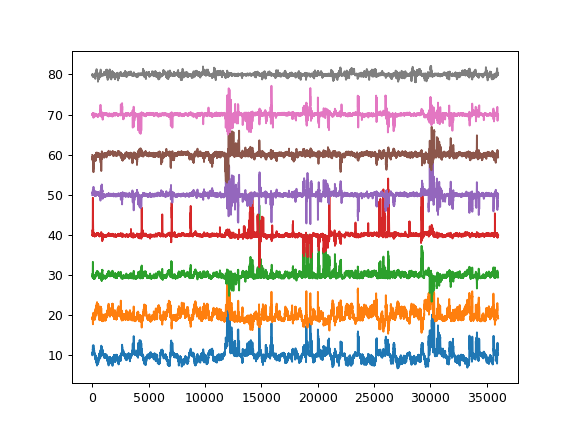

In [24]:
%matplotlib notebook
plt.figure()
plt.plot(comp.T + 10*np.arange(1,9))

# Figure out the number of factors
Method idea is to do cross validation and somehow use the predicted nmf factors on the test set to evaluate the model performance. Tough to say how

In [ ]:
## CV
num_minutes = 10
indices_for_regression = np.arange(int(Fs*60*num_minutes),neural_data_toUse.shape[1])
neural_data_for_regression = welford_moving_2D.make_rollingZScore(neural_data_toUse.T, win_roll=int(Fs*60*num_minutes)).T[:,indices_for_regression]
neural_data_for_nmf = neural_data_toUse[:,indices_for_regression]
cv_idx = cross_validation.group_split(
    n_splits=4,
    n_samples=neural_data_for_nmf.shape[1],
    group_size=2*60*30, 
    test_size=0.3
)
X_train = [ ]
X_test  = [neural_data_for_nmf[:,cv[1]] for cv in cv_idx]

## NMF on training
factors_all = []
for i_rank, rank in enumerate(range(2,8)):
    factors_cv = []
    for cv in cv_idx:
        factors = tl.decomposition.non_negative_parafac(
                    tl.tensor(neural_data_for_nmf[:,cv[0]]).to('cuda'),
                    rank=rank,
                    n_iter_max=500,
                    init='random',
                    svd='numpy_svd', 
                    tol=1e-06,
                #     random_state=None,
                    verbose=0,
                #     normalize_factors=False,
                #     return_errors=False,
                #     mask=None,
                #     cvg_criterion='abs_rec_error',
                #     fixed_modes=None
                )
        
        
        ## z-score NMF outputs
        factors_temporal_nmf_zscore = scipy.stats.zscore(factors,axis=1)
        theta, factor_preds = linear_regression.OLS(neural_data_for_regression[:,cv[0]], factors_temporal_nmf_zscore)
        test_preds = np.dot(theta, neural_data_for_regression[:,cv[1]])
        similarity.orthogonalize(test_preds, neural_data_for_regression[:,cv[1]])
        factors_cv.append(factors)
    factors_all.append(factors_cv)
    
## regression model on training

## EV on test

In [ ]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return dot(Phi, R)